## Fast gradient sign method
The fast gradient sign method works by using the gradients of the neural network to create an adversarial example. For an input image, the method uses the gradients of the loss with respect to the input image to create a new image that maximises the loss. This new image is called the adversarial image. This can be summarised using the following expression:
$$adv\_x = x + \epsilon*\text{sign}(\nabla_xJ(\theta, x, y))$$

where 

*   adv_x : Adversarial image.
*   x : Original input image.
*   y : Original input label.
*   $\epsilon$ : Multiplier to ensure the perturbations are small.
*   $\theta$ : Model parameters.
*   $J$ : Loss.

In [1]:
%tensorflow_version 1.x
import tensorflow as tf
import tensorflow.contrib.slim as slim
import tensorflow.contrib.slim.nets as nets
import matplotlib as mpl
import matplotlib.pyplot as plt
import PIL
import numpy as np
import json
from urllib.request import urlretrieve

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



## The class of Adversarial Example
1. neural networks: Inception v3
2. adversarial attack method: FGSM

In [0]:
class AdversarialExample:
  def __init__(self):

    self._initialize_session()
    self._build_graph()
    self._restore_model()

  def _initialize_session(self):
    tf.logging.set_verbosity(tf.logging.ERROR)
    self.sess = tf.InteractiveSession()
  
  def _build_graph(self):
    # define inputs
    self.image = tf.Variable(tf.zeros((299, 299, 3)))

    preprocessed = tf.multiply(tf.subtract(tf.expand_dims(self.image, 0), 0.5), 2.0)
    arg_scope = nets.inception.inception_v3_arg_scope(weight_decay=0.0)
    with slim.arg_scope(arg_scope):
        logits, _ = nets.inception.inception_v3(
            preprocessed, 1001, is_training=False, reuse=False)
        # ignore background class
        self.logits = logits[:,1:]
        # probabilities
        self.probs = tf.nn.softmax(logits)
  
  def _restore_model(self):
    restore_vars = [
        var for var in tf.global_variables()
        if var.name.startswith('InceptionV3/')
    ]
    self.saver = tf.train.Saver(restore_vars)
    self.saver.restore(self.sess, 'drive/My Drive/adversarial attacks/checkpoint/inception_v3.ckpt')

  def classify(self, img, correct_class=None, target_class=None):
    imagenet_json, _ = urlretrieve(
        'https://raw.githubusercontent.com/xunguangwang/Adversarial-Attacks/master/imagenet.json')
    with open(imagenet_json) as f:
      imagenet_labels = json.load(f)

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 8))
    fig.sca(ax1)
    p = self.sess.run(self.probs, feed_dict={self.image: img})[0]
    ax1.imshow(img)
    fig.sca(ax1)
    
    topk = list(p.argsort()[-10:][::-1])
    topprobs = p[topk]
    barlist = ax2.bar(range(10), topprobs)
    if target_class in topk:
        barlist[topk.index(target_class)].set_color('r')
    if correct_class in topk:
        barlist[topk.index(correct_class)].set_color('g')
    plt.sca(ax2)
    plt.ylim([0, 1.1])
    plt.xticks(range(10),
               [imagenet_labels[i][:15] for i in topk],
               rotation='vertical')
    fig.subplots_adjust(bottom=0.2)
    plt.show()

  def fgsm_attack(self, image, label, epsilon=0):
    label = tf.one_hot(label, 1000)

    loss = tf.nn.softmax_cross_entropy_with_logits(logits=self.logits, labels=[label])
    # Get the gradients of the loss w.r.t to the input image.
    gradient = tf.gradients(loss, self.image)
    # Get the sign of the gradients to create the perturbation
    signed_grad = tf.sign(gradient)
    perturbation = epsilon*signed_grad[0]
    # Adversarial image
    adv_image = tf.clip_by_value(image + perturbation, 0, 1)
    
    return self.sess.run([adv_image, perturbation], feed_dict={self.image: img})

## Original image
* get the original image and preprocess it
* classify the image by inecption v3

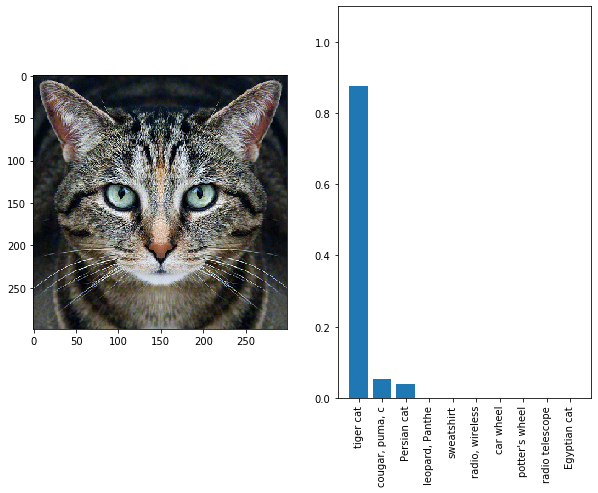

In [3]:
img_path, _ = urlretrieve('https://raw.githubusercontent.com/xunguangwang/Adversarial-Attacks/master/images/cat.jpg')
img_class = 281
img = PIL.Image.open(img_path)
big_dim = max(img.width, img.height)
wide = img.width > img.height
new_w = 299 if not wide else int(img.width * 299 / img.height)
new_h = 299 if wide else int(img.height * 299 / img.width)
img = img.resize((new_w, new_h)).crop((0, 0, 299, 299))
img = (np.asarray(img) / 255.0).astype(np.float32)

model = AdversarialExample()
model.classify(img, correct_class=img_class)

## Create the adversarial image
* to show the perturbation ($\epsilon*\text{sign}(\nabla_xJ(\theta, x, y))$)

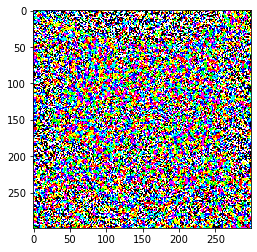

In [4]:
epsilon = 0.01
adv_image,perturbation = model.fgsm_attack(img, img_class, epsilon)
plt.imshow((perturbation+epsilon)/(2*epsilon))

* we can see that the model misclassified the adversarial image

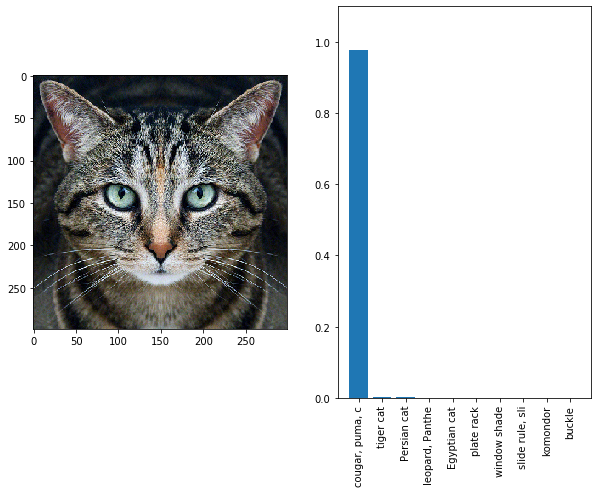

In [5]:
model.classify(adv_image, correct_class=img_class)